# Quora question pairs competition - 2017/06

## Introduction
* The Kaggle competition *Quora Question Pairs* provides a data set of 404,288 question pairs with the task of identifying duplicate questions. A succesful model will take a question pair and predict whether the two questions comprising the pair are duplicates or equivalent questions.
* I chose this competition for my capstone project for several reasons. The MLND curriculum did not touch on natural language processing (NLP) at all and I wanted to gain some experience in this area of machine learning. Choosing a Kaggle competition seemed a good choice as this provides both a well scrutinized data set as well as a benchmark for my project. I specifically decided against an image processing project as this did not seem feasible to do on a low-perfromance laptop machine. When writing my project proposal I did not appreaciate the computational needs for NLP tasks and ended up having to run my script on AWS EC2 instances.
* This script is distinct from - though similar to - my submission to the Kaggle competition. The primary reason for this is that the Kaggle competition is scored or validated with a test data set that is separate form the training data set. While this obviously means that the data splitting for the training and validation steps will be different, the specific circumstances of the data used here result in additional differences. The original test data do not contain any true labels to enable the Kaggle team to score submissions without participants cheating. The two data sets (train and test) are not just random subsets of their pool of question pairs though. The test data set contains a significant amount of computer-generated questions - again used to prevent cheating. The patterns of these computer-generated questions are considerably different from the training data though. This means that scripts used to compete in the Kaggle competition have 'hand crafted' features (including both thei weight of duplicate questions and text processing steps) that are geared toward getting good scores on the test data set. In this submission, the only data used are from the *train.csv* file provided by Quora through Kaggle and all data processing is aimed at modeling these data as well as possible.
* In my capstone project proposal, I suggested that using a gradient boosting mechanism might be the best algorithm to model this NLP problem. After initially building a solution that used XGboost, I decided to swithc and use a deep learning recurrent network using Keras though. While the best solutions for the Kaggle competition are indeed making use of XGboost - indicating it is a good choice - my motive here was mostly to gain more experience with Keras as well as gpu instances on AWS EC2.
* For this project, I used Python 3.6, Keras 2.0.2, and tensorflow-gpu 1.0.1 on a linux machine. One reason for using Python 3.6 was to enable execution of this script also on Windows systems where the tensorflow gpu version does not play well with Python 2.x as far as I know.

## Project scope and workflow

The Kaggle competition *Quora Question Pairs* provides a data set of 404,288 question pairs with the task of identifying duplicate questions. A succesful model will take a question pair and predict whether the two questions comprising the pair are duplicates or equivalent questions. For training purposes, the data set contains a column *is_duplicate*, labelling pairs as duplicates. For scoring of the Kaggle competition, the trained model is run on a *test* dataset and the result submitted to Kaggle for scoring. Since the *test* set does not contain the duplication label, any independent accuracy score will have to be calculated on the original *train* dataset.  
For this purpose, the original *train* data will be split into training and testing subsets, on which I can train and validate the model. A comparison between this sccuracy and the accuracy calculated by Kaggle based on the original *test* set seems prudent and will be provided at the end.  
The task covered here is my first NLP project. While building the classifier will be very similar to other machine learning problems, the data processing steps necessary are specific to language processing and crucial to a well performing model.  
After experimenting with a variety of different libraries, my workflow for this project is as follows.
* Load the data
 * While two files, *train.csv* and *test.csv* are provided by Kaggle, for the MLND realization of this project, only the train data can be utilized. Hence this data as to be split up in train and test subsets.
* Process the data
 * To make the data accessible to a machine learning classifier, the question pairs have to be processed and normalized.
 * Attributes like case and punctuation are generally not informative but enlarge the feauter space. After extracting all words of a question, it is prudent to reduce those to their lemmas, as those minimize the feature space while retaining - almost - all meaning of the original words.
 * Removing stop words - i.e. often redundant and very frequent words - seemed tempting to reduce the feauter space further but actually proved to decrease the model accuracy.
 * Weigh duplicates and non-duplicates given that they are not equally frequent in the data used here.
 * Embedding the questions into word vectors. This is the nlp equivalent of one-hot-encoding to convert the words into an input suitable for a neural network. Several libraries are available for this, with the most popular being nltk. I opted for using the spacy module with one of the reasons being a pipe() method optimizing tokenizing the text on multiprocessor systems. Spacy uses the Glove vectors for embedding words just like nltk, but comes with its own vocabulary and does offer mode avanced semantic analysis that I initially thought might be helpful but didn't utilize in the final implementation.
* Create and train a model to classify all question pairs
 * I chose a recurrent neural network to model this problem. To add long-term memory, I used a Long-Short-Term-Memory (LSTM) layer provided by Keras. There are are multitudes of somewhat suitable options for neural network layer combinations. The LSTM layer - following an embedding layer for the word vectors - showed up in my initial research to be efficient for text analysis and comparisons. Variations in layer combinations I tried were mostly focussing on whn to combine the two questions comprising a pair within the neural network stack and what compromise between depth of the stack and number of features to pick while keeping computational time reasonable.

In [1]:
# Ipython stuff
%matplotlib inline

In [2]:
# Generic imports
import numpy as np
import pandas as pd
import os
from time import time, localtime
import urllib
import requests
import zipfile
import matplotlib.pyplot as plt
import re
import pickle
from scipy.sparse import csr_matrix as csr
import multiprocessing
import random

# language related imports
import string
# from nltk.stem.wordnet import WordNetLemmatizer
# from nltk.tokenize import wordpunct_tokenize, RegexpTokenizer
from gensim import models # Contains the Word2Vec model
import spacy
from sklearn.feature_extraction.text import TfidfTransformer, TfidfVectorizer, CountVectorizer

#ML related imports
from sklearn.model_selection import train_test_split, KFold
import xgboost as xgb

# Keras specific imports
from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, MaxoutDense
from keras.layers.merge import concatenate
from keras.models import Model, Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

/home/seb/anaconda2/envs/py36/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
# Parameters:
MAX_THREAD = multiprocessing.cpu_count() - 1 # keeps system responsive
MAX_Q_LENGTH = 42
MAX_WORDS = 230000
WORD_VEC_LEN = 300 # default glove
SPLIT = 0.2 # test_validation split
WEIGHT_0 = 0.631 # found after initial analysis
WEIGHT_1 = 0.369 

## Loading the data
* As long as the *train.csv* file is present in the notbook directory, this will load the data.  
* We see that there are 404,288 question pairs with 36.9% of them being labelled as duplicates.
* Looking at the histogram below, we see that while the majority of questions are unique, i.e. appearing only once, there is a significant tail of questions appearing mutiple times with a maximum of 50 occurrences for a question. This is only the count distribution for the first question and is not a measure of duplicate pairs. It does show however, that Quora enlarged their question pair pool by re-using a significant number of questions by pairing them with a mutitude of other questions.

    qid1  qid2                                          question1  \
id                                                                  
0      1     2  What is the step by step guide to invest in sh...   
1      3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2      5     6  How can I increase the speed of my internet co...   
3      7     8  Why am I mentally very lonely? How can I solve...   
4      9    10  Which one dissolve in water quikly sugar, salt...   

                                            question2  is_duplicate  
id                                                                   
0   What is the step by step guide to invest in sh...             0  
1   What would happen if the Indian government sto...             0  
2   How can Internet speed be increased by hacking...             0  
3   Find the remainder when [math]23^{24}[/math] i...             0  
4             Which fish would survive in salt water?             0  
-----------------------
Nu

(array([  2.36325000e+05,   3.31350000e+04,   1.04910000e+04,
          4.03900000e+03,   2.09100000e+03,   1.13600000e+03,
          7.62000000e+02,   5.36000000e+02,   3.45000000e+02,
          3.16000000e+02,   2.24000000e+02,   1.85000000e+02,
          1.42000000e+02,   1.25000000e+02,   9.70000000e+01,
          6.80000000e+01,   6.40000000e+01,   6.00000000e+01,
          4.40000000e+01,   5.10000000e+01,   3.30000000e+01,
          2.30000000e+01,   2.10000000e+01,   1.60000000e+01,
          2.30000000e+01,   9.00000000e+00,   7.00000000e+00,
          1.20000000e+01,   1.20000000e+01,   1.20000000e+01,
          6.00000000e+00,   7.00000000e+00,   2.00000000e+00,
          5.00000000e+00,   3.00000000e+00,   5.00000000e+00,
          1.00000000e+00,   2.00000000e+00,   3.00000000e+00,
          2.00000000e+00,   3.00000000e+00,   4.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   2.00000000e+00,
          1.00000000e+00,   3.00000000e+00,   1.00000000e+00,
        

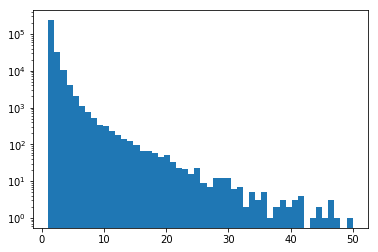

In [4]:
# Check whether data is in project folder and unzip if not
# dirname = os.path.split(os.path.abspath(__file__))[0]
dfiles = ['train.csv'] # , 'test.csv' only needed for Kaggle submission
url = 'https://www.kaggle.com/c/quora-question-pairs/download/'
files = os.listdir()
for f in dfiles:
    if f not in files:
        try:
            print(f'Extracting {f}.')
            tf = f+'.zip'
            with zipfile.ZipFile(tf) as z:
                z.extractall()
            os.remove(tf)
        except:
            print(f'Could not locate {f} data file, please download from {url}. You will need an acitvated Kaggle account to login.')
# get training data set
train = pd.read_csv(dfiles[0], index_col='id').dropna()
print(train.head())
print('-'*23)
print(f"Number of question pairs in training set: {len(train)}. \nThis includes {train['is_duplicate'].sum()} - or {train['is_duplicate'].mean()*100:.1f}% - duplicates.")
# Show histogram of value_counts
plt.hist(train['question1'].value_counts(), bins = 50, log=True)

51.0


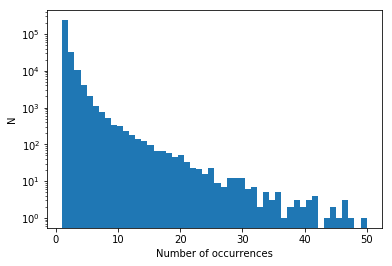

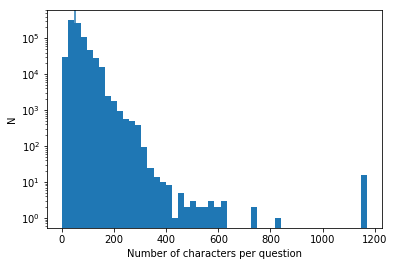

In [5]:
# Show histogram of value_counts
plt.hist(train['question1'].value_counts(), bins = 50, log=True)
plt.xlabel('Number of occurrences')
plt.ylabel('N')

qs = train['question1'].append(train['question2'])
plt.figure()
plt.hist([len(s) for s in qs.values], bins = 50, log=True)
plt.xlabel('Number of characters per question')
plt.ylabel('N')
plt.axvline(np.median([len(s) for s in qs.values]))
# plt.xlim([0,10])
print(np.median([len(s) for s in qs.values]))

In [5]:
train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


Goal of top 33% requires logloss below 0.3100


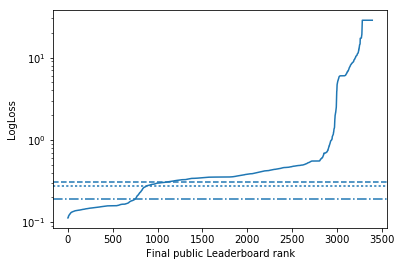

In [6]:

fname = r'quora-question-pairs_public_leaderboard.csv'
df = pd.read_csv(fname)
sdf = df.groupby(['TeamId']).min()
scores = np.sort(sdf['Score'].values)
goal = sdf['Score'].quantile(0.33)
print(f'Goal of top 33% requires logloss below {goal:.4f}')
plt.plot(scores)
plt.semilogy()
plt.ylabel('LogLoss')
plt.xlabel('Final public Leaderboard rank')
plt.axhline(goal, ls='dashed')
plt.axhline(0.19, ls='dashdot')
plt.axhline(0.277, ls='dotted')

In [7]:
train = train[:1000]

## Clean the data
This is a fairly basic cleaning of the data to prepare it for the tokenizer or lemmatization. 

In [8]:
# pre process training data, replace common spelling
# Mostly common sense, some weird cases taken from Kaggle discussions
def clean_text_df(df):
    '''Take df and clean up text in question cols.'''
    for q in ['question1', 'question2']:
        df[q] = df[q].str.lower()
        df[q] = df[q].str.replace("'s", " is")
        df[q] = df[q].str.replace("'ll", " will")
        df[q] = df[q].str.replace("'d ", " would ")
        df[q] = df[q].str.replace("can't", "cannot")
        df[q] = df[q].str.replace("n't", " not")
        df[q] = df[q].str.replace("i'm", "i am")
        df[q] = df[q].str.replace(" u s ", "american")
        df[q] = df[q].str.replace(" e g ", " eg ")
        df[q] = df[q].str.replace("e - mail", "email")
        # test: remove very common words (could do by tokens, too)
#         df[q] = df[q].str.replace("what ", "")
#         df[q] = df[q].str.replace(" is ", " ")
#         df[q] = df[q].str.replace(" the ", " ")


# clean training data
clean_text_df(train)

In [7]:
# Check the text after pre-processing
train.head()

,qid1,qid2,question1,question2,is_duplicate
id,,,,,
0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0
1,3,4,what is the story of kohinoor (koh-i-noor) dia...,what would happen if the indian government sto...,0
2,5,6,how can i increase the speed of my internet co...,how can internet speed be increased by hacking...,0
3,7,8,why am i mentally very lonely? how can i solve...,find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"which one dissolve in water quikly sugar, salt...",which fish would survive in salt water?,0


While working with dataframes is convenient initially, we now get the questions into lists to feed them into the tokenizer.

In [9]:
# assign questions to lists and lemmatize
q1 = train['question1'].values
q2 = train['question2'].values
labels = np.array(train['is_duplicate'].values)

#skip lemmatize for now

The questions are now tokenized and the reult be fitted on the vocabulary, i.e. the list of all questions. This will provide a means of tfidf normalization, i.e. builds a word index of our vocabulary with the frequency of each word occurring in the vocabulary. There are different ways to go about tokenizing the words. Here I chose the built-in tokenizer provided by Keras.  
The reulting lists have to be padded because not all questions are of equal length and the keras input layer requires a matrix, i.e. an array of vectors with identical length.

In [10]:
# Now tokenize questions; originally used spacy, but had issues with parsing into keras, might retry later
# HAve to figure out how to get equivalent spacy word_index
start = time()
tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(list(q1) + list(q2)) # might add test questions, but they contain fake text...

qs1 = tokenizer.texts_to_sequences(q1)
qs2 = tokenizer.texts_to_sequences(q2)
# test_qs1 = tokenizer.texts_to_sequences(test_q1)
# test_qs2 = tokenizer.texts_to_sequences(test_q2)

word_index = tokenizer.word_index
print('Unique tokens: {}'.format(len(word_index)))

# padding tokens to get matrices with matching sizes
X1 = pad_sequences(qs1, maxlen=MAX_Q_LENGTH)
X2 = pad_sequences(qs2, maxlen=MAX_Q_LENGTH)
print('Input data shape: {}'.format(X1.shape))
print('took {}s.'.format(time()-start))

Unique tokens: 3957
Input data shape: (1000, 42)
took 0.15395355224609375s.


One can't use the words or lemmata as a direct input to Keras but has to embed them using a vector representation. Here I am using spacy which utilizes the Glove vector implementation of word vectors having the standard length of 300.

In [11]:
# embeddings / word vectors
# Initally tried spacy solution, but keras/word2vec seems easier?
nlp = spacy.load('en_core_web_md')
start = time()
no_of_words = min(MAX_WORDS, len(word_index))+1

vectors = np.zeros((no_of_words, WORD_VEC_LEN))

for i, w in enumerate(nlp.pipe(list(word_index.keys()), batch_size=42, n_threads=MAX_THREAD)):
    if w.has_vector:
        vectors[i] = w.vector
# words with missing vectors - better with larger model
print('Number of words without vector: %d' % np.sum(np.sum(vectors, axis=1) == 0))
print('took {}s.'.format(time()-start))

Number of words without vector: 1364
took 0.30953049659729004s.


Before feeding the data into any machine learning algorithm, one has to split it into train and test sets.

In [12]:
# HAve to split train/validation set (can't use sklearn?)
random.seed(42)
rand = np.random.permutation(len(X1))
ind_train = rand[:int(len(X1)*(1-SPLIT))]
ind_val = rand[int(len(X1)*(1-SPLIT)):]
# train subset
X1_train = np.vstack((X1[ind_train], X2[ind_train]))
X2_train = np.vstack((X2[ind_train], X1[ind_train]))
labels_train = np.concatenate((labels[ind_train], labels[ind_train]))
# test subset
X1_val = np.vstack((X1[ind_val], X2[ind_val]))
X2_val = np.vstack((X2[ind_val], X1[ind_val]))
labels_val = np.concatenate((labels[ind_val], labels[ind_val]))

val_weights = np.ones(len(labels_val))
# Have to weigh duplicates higher because they don't show up 50%
val_weights *= WEIGHT_1
val_weights[labels_val==0] = WEIGHT_0
# also weights for keras model:
fit_weights  = {0: WEIGHT_0, 1: WEIGHT_1}

### Network layer design
The neural network layers are now defined below. The layout below is the best configuration I could find based on the validation score.  
A quick summary of the network design:
* The parameters define the width of the feature space, though more indirectly than in a RandomForest or GradientDescent algorithm. While a larger number of features tends to improve accuracy, it does increase memory and time requirements and the benefit tends to saturate above 200 for the input layer feature space.
* Both inut data sets, the *question1* and the *question2* columns in their pre-processed forms are independently fed to and embedded into the Keras network. They both go through a recurrent network layer, a LSTM layer to be precise. I chose the LSTM layer in the hope of retaining long-term memory because this algorithm is not primarily looking for 'local' patterns as in image pattern recognition but rather is trying to establish global - or long-term - patterns or correlations.
* Given that we are interested in a correlation between the two questions making up a question pair, the two input layer stacks are now merged by concatenating them.
* This is followed by a dropout layer to reduce overfitting and a normalization layer.
* Using another lstm layer on the merged stack proved to improve the accuracy.
* After that, a Maxout layer is used to reduce the feature space with minimal information loss, followed by a dense layer and finally the output activation.

In [13]:
# Now finally get to the ML part, setup keras network layout:
# First some params for the model:
lstm_units = 200 # 
dense_units = 150 # 
lstm_drop = 0.25
dense_drop = 0.25
                          
emb_layer = Embedding(no_of_words,
        WORD_VEC_LEN,
        weights=[vectors],
        input_length=MAX_Q_LENGTH,
        trainable=False)
lstm_layer = LSTM(lstm_units, dropout=lstm_drop, recurrent_dropout=lstm_drop, return_sequences=True)
# input layers; both questions go through an lstm independently after mebedding
q1_in = Input(shape=(MAX_Q_LENGTH,), dtype='int32')
emb_layer_1 = emb_layer(q1_in)
X_1 = lstm_layer(emb_layer_1)
q2_in = Input(shape=(MAX_Q_LENGTH,), dtype='int32')
emb_layer_2 = emb_layer(q2_in)
X_2 = lstm_layer(emb_layer_2)
# Merging: concatenate q1 and q2 layers
conc = concatenate([X_1, X_2]) # 
conc = Dropout(dense_drop)(conc)
conc = BatchNormalization()(conc)

# add lstm for merged layer
conc = LSTM(lstm_units, return_sequences=False)(conc)
conc = Dropout(0.25)(conc)
conc = BatchNormalization()(conc)

conc = MaxoutDense(125)(conc)
conc = Dropout(dense_drop)(conc)
conc = BatchNormalization()(conc)

conc = Dense(dense_units, activation='relu')(conc)
conc = Dropout(dense_drop)(conc)
# print(conc.shape)

pred = Dense(1, activation='sigmoid')(conc)


/home/seb/anaconda2/envs/py36/lib/python3.6/site-packages/keras/legacy/layers.py:525: UserWarning: The `MaxoutDense` layer is deprecated and will be removed after 06/2017.
  warnings.warn('The `MaxoutDense` layer is deprecated '


In [14]:
from keras.utils import plot_model
model = Model(inputs=[q1_in, q2_in], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
plot_model(model, to_file='model.png')

### Train the network
* Feed the prepared date to the Keras model and fit it. Use *binary crossentropy* for the accuracy score, consistent with the *log loss* used for the Kaggle competition.
* The model is set to automatically stop if the validation accuracy did not improve for 5 epochs, avoiding unnecessary computation time.
* The parameters used here might not work on some systems, reducing the batch size will help when running out of memory but increase running time. The training took just under 150min on an AWS EC2 p2 gpu instance.

In [14]:
# Now train model, get score history and save best one

fit_batch = 2048
pred_batch = 2048
epochs = 30
model = Model(inputs=[q1_in, q2_in], outputs=pred)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])
#model.summary()
print('Model hyperparameters are: {:.2f}, {:.2f}, {:.2f}, {:.2f}'.format(lstm_units, dense_units, lstm_drop, dense_drop))

stop = EarlyStopping(monitor='val_loss', patience=5)
best_save = 'ud_merged_lstm_act+maxout_rem_stop_{:.2f}_{:.2f}__'.format(lstm_units, dense_units) + '_'.join(map(str,localtime()[3:6])) + '.h5'
chkpt = ModelCheckpoint(best_save, save_best_only=True, save_weights_only=True)

hist = model.fit([X1_train, X2_train], labels_train,
                 validation_data=([X1_val, X2_val], labels_val, val_weights),
                 epochs=epochs, batch_size=fit_batch, shuffle=True,
                 class_weight=fit_weights, callbacks=[stop, chkpt])


Model hyperparameters are: 200.00, 150.00, 0.25, 0.25
Train on 646860 samples, validate on 161716 samples
Epoch 1/30
646860/646860 [==============================] - 422s - loss: 0.2478 - acc: 0.7166 - val_loss: 0.2854 - val_acc: 0.6311
Epoch 2/30
646860/646860 [==============================] - 423s - loss: 0.2273 - acc: 0.7493 - val_loss: 0.2291 - val_acc: 0.7528
Epoch 3/30
646860/646860 [==============================] - 423s - loss: 0.2162 - acc: 0.7653 - val_loss: 0.2169 - val_acc: 0.7800
Epoch 4/30
646860/646860 [==============================] - 423s - loss: 0.2074 - acc: 0.7763 - val_loss: 0.2106 - val_acc: 0.7800
Epoch 5/30
646860/646860 [==============================] - 423s - loss: 0.2004 - acc: 0.7859 - val_loss: 0.2066 - val_acc: 0.7891
Epoch 6/30
646860/646860 [==============================] - 422s - loss: 0.1945 - acc: 0.7934 - val_loss: 0.2087 - val_acc: 0.7943
Epoch 7/30
646860/646860 [==============================] - 422s - loss: 0.1896 - acc: 0.7995 - val_loss: 0.

### Result
The best cross entropy validation score I could get was 0.19, which is well below the ~0.31 goal I set myself in the capstone proposal based on the scores of the top 30% in the Kaggle competition. As mentioned in the introduction, the comparison between scores of the validation split of the *train* data and the submissions based on the *test* data is somewhat biased. This is due to the fact that submissions to the competition have features tailored to predict the *test* data set which differs significantly from the *train* data or any subset of it. Using this model I was able to achieve a Kaggle accuracy score of 0.277, which is significantly higher than the validation score yet still beating my initial benchmark.

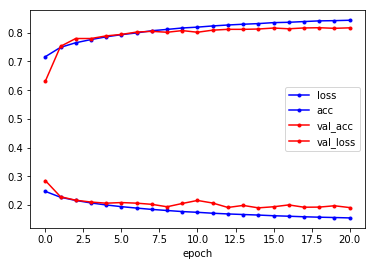

In [15]:
plt.plot(hist.history['loss'],'b.-', label='loss')
plt.plot(hist.history['acc'],'b.-', label='acc')
plt.plot(hist.history['val_acc'],'r.-', label='val_acc')
plt.plot(hist.history['val_loss'],'r.-', label='val_loss')
plt.xlabel('epoch')
plt.legend()
best_score = min(hist.history['val_loss'])
print('Best score was {}.'.format(best_score))